For this exercise we will work through the different steps of a linear regression workflow.  We will:

### FSM
1. Load in the dataset: inspect the overall shape, duplicate entries, and na's.
2. Identify the continuous target variable
3. Perform Initial EDA: correlation plots
4. Build a FSM (First Simple Model) with statsmodels/Build a FSM with sklearn
5. Check the assumptions of linear regression  

### Iterate: Build a better model
6. Identify independent variables, and differentiate between numerical vs categorical features
7. Identify and remove outliers  
8. Check for duplicate entries and nas
9. Scale continuous features  
10. Add more continuous features refit, compare R2, check assumptions  

### Iterate: Build a better model
10. Encode categorical variables
11. Add a categorical variable to the model, refit compare R2, check assumptions


## The Dataset
We will use a dataset from [Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who). It contains data collected by the WHO about life expectancy and potentially-related factors.  The information is aggregated on a per-country per-year basis.

The following questions have been posed. Read them and keep them in your mind when building your model.  We will reference them as we proceed through the workflow.

1. Do various predicting factors which have been chosen initially really affect life expectancy? Which predicting variables actually affect life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How do infant and adult mortality rates affect life expectancy?
4. Does life expectancy have positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of immunization coverage on life Expectancy?

### 1. Load in the dataset and check the overall shape


In [110]:
# 0. Load in the dataset and check the overall shape

# load in the dataset
df = pd.read_csv('data/life_expectancy.csv')

# How many records are in the data set?
records = df.shape[0]

# How many columns are in the dataset?
columns = len(df.columns)

# Check for duplicate entries
df.duplicated().sum()

# Check for na's (just look to get an idea; don't drop or impute yet)
df.isna().sum()


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

### 3. What does a row in the dataframe represent?


In [148]:
"""
Each row represents a *year* of a *country's* health data.
"""

"\nEach row represents a *year* of a *country's* health data.\n"

### 2: Identify the continous target variable

In [111]:
# 1. Identify the continuous target variable of interest
df['Life expectancy ']



0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: Life expectancy , Length: 2938, dtype: float64

If you had problems isolating that variable, don't worry.  That is on purpose! 
There can be odd, burdensome inconsistencies in naming of data.
Let's use our Python skills to wipe out the naming inconsistencies.

### Clean up the column names. 
There are many ways to do this. One way of doing so, outlined below, uses the columns attribute of the dataframe.  Then, using a list comprehension or for loop, we can manipulate the column name strings using methods that come with the string class.

In [115]:
# Lastly, to make things easier to interpet, set the target to column index 0

cols = list(df.columns)
cols = [cols[3]] + cols[:3] + cols[4:]
df = df[cols]


In [116]:

# 1. Gather column names into a variable
columns = df.columns

# 2. Strip whitespace from the ends
columns = [column.strip() for column in columns]

# 3. Replace white space with underscores
columns = [column.replace(' ', '_') for column in columns]

# 4. Make all columns characters lowercase
columns = [column.lower() for column in columns]

# 5. Reset the column names of the dataframe
df.columns = columns

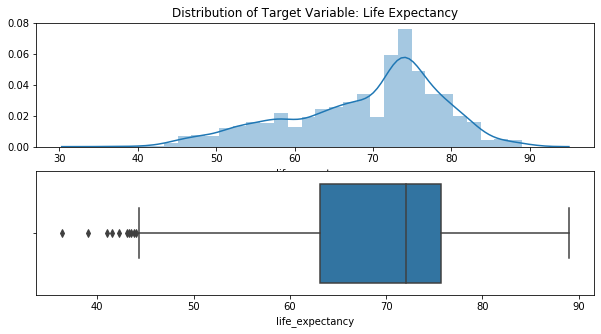

In [118]:
# Revisit the continuous target variable.  
# Explore it a bit.  Plot it's distribution and boxplot

fig, ax = plt.subplots(2,1, figsize=(10,5))
sns.distplot(df.life_expectancy, ax = ax[0])
sns.boxplot(df.life_expectancy, ax= ax[1])

ax[0].set_title('Distribution of Target Variable: Life Expectancy');

# 3. Perform Initial EDA

There are a lot of variables here!  Let's look at a correlation matrix to see which ones might be the most useful.  (Here we are looking for variables that are highly correlated with the target variable, but not highly correlated with other input variables)

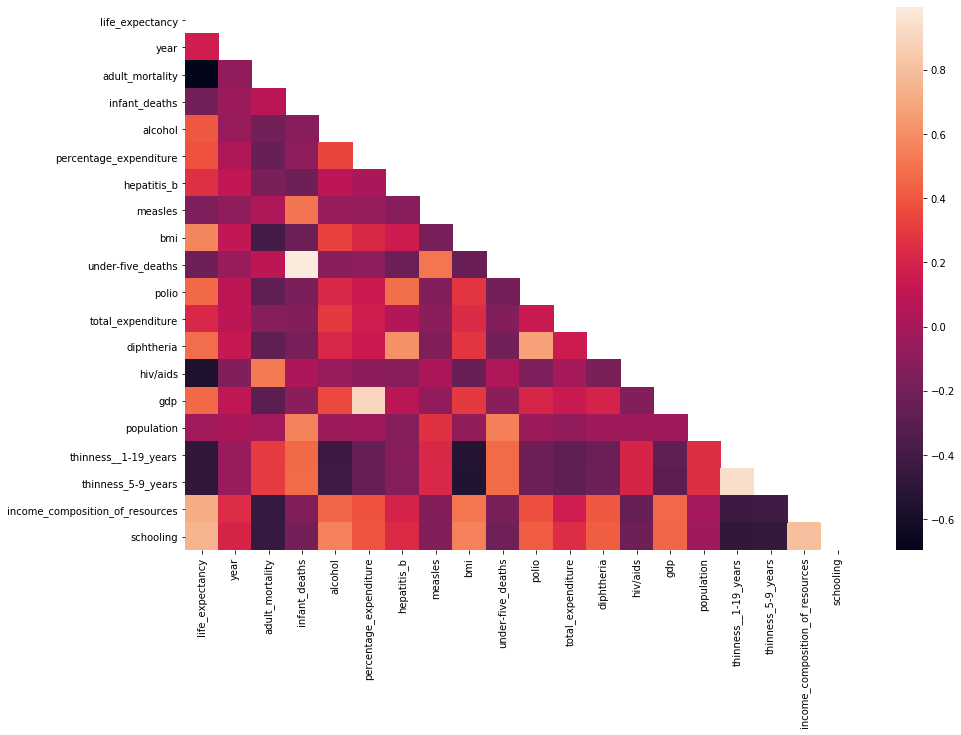

In [123]:
# create a correlation matrix
# first, just use the datafram .corr() method to output a numerical matrix
df.corr()

# Then pass the above code into Seaborn's heatmap plot
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), mask=mask)

In [125]:
# From the heatmap, which features have high correlation? 
"Schooling, income_composition_of_resources, BMI"

'Schooling, income_'

Use seaborn's pairplot function on the three features above plus life_expectancy.  
Note: we would usually start right off by using a pairplot, but because we have so many features, the pairplot would be unwieldy.

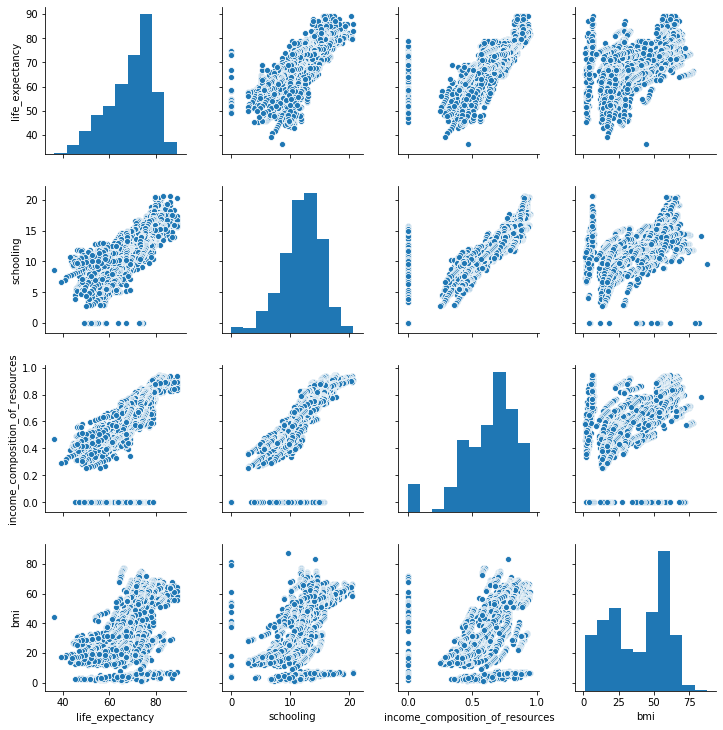

In [129]:
high_correlation_df = df[['life_expectancy', 'schooling', 
                         'income_composition_of_resources', 'bmi']]

sns.pairplot(high_correlation_df)

Judging from the top row of the pairplot, one feature's correlation to the target is a bit fuzzier than the rest. 
Inspecting other cells of the pairplot, the other two features show covariance. 
Given those two insights, choose one feature to build the First Simple Model with.
Consider also whether choosing one of the positively correlated features above the others would help answer any of the question listed at the beginning of the notebook.


In [131]:

"""
It looks like the correlation with BMI is a little fuzzier than the others, 
so let's exclude it for now.  
`Schooling` and `Income_Composition_of_Resources` are highly correlated with both life expectancy and each other, 
so let's only include one of them. 
`Schooling` seems like a good choice because it would allow us to answer Question 5.
"""


"\nIt looks like the correlation with BMI is a little fuzzier than the others, \nso let's exclude it for now.  \n`Schooling` and `Income_Composition_of_Resources` are highly correlated with both life expectancy and each other, \nso let's only include one of them. \n`Schooling` seems like a good choice because it would allow us to answer Question 5.\n"

# 4. Build an FSM

## 1. FSM with Statsmodels


In [136]:
from statsmodels.formula.api import ols
# Create a dataframe with only the target and the chosen high-positive corellation feature

fsm_df = df[["schooling", "life_expectancy"]].copy()
fsm_df.dropna(inplace=True)

# build the R-style formula. The format is "target~feature_1 + feature_2 + feature_3"

formula = "life_expectancy ~ schooling"

# Fit the model on the dataframe composed of the two features

fsm = ols(formula=formula, data=fsm_df).fit()

In [162]:
# The object also has attributes associated with the ouput, such as: rsquared, and params.
# save those values to the variables below.

rsquared = fsm.rsquared
params = fsm.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)
              

Rsquared of FSM: 0.565467096558071
----------
Beta values of FSM:
Intercept    44.108889
schooling     2.103453
dtype: float64


Interpret the result of the FSM.  What does the R Squared tell you? Remember the formula for:

$\Large R^2 = 1 - \frac{SSE}{SST}$

Also, interepret the coefficients.  If we increase the value of our independent variable by 1, what does it mean for our predicted value?

What is will our model predict the value of Life Expectancy to be for a country with 0 years of school on average?

In [164]:
'''
Not too bad.  We are only explaining about 57% of the variance in life expectancy, but we only have one feature so far and it's statistically significant at an alpha of 0.05.

We could stop right now and say that according to our model:

 - A country with zero years of schooling on average is expected to have a life expectancy of 44.1 years
 - For each additional average year of schooling, we expect life expectancy to increase by 2.1 years
 
'''

"\nNot too bad.  We are only explaining about 57% of the variance in life expectancy, but we only have one feature so far and it's statistically significant at an alpha of 0.05.\n\nWe could stop right now and say that according to our model:\n\n - A country with zero years of schooling on average is expected to have a life expectancy of 44.1 years\n - For each additional average year of schooling, we expect life expectancy to increase by 2.1 years\n \n"

# 5 Check the assumptions of Linear Regression

### 1. Linearity

#### Linearity

Linear regression assumes that the input variable linearly predicts the output variable.  We already qualitatively checked that with a scatter plot.  But I also think it's a good idea to use a statistical test.  This one is the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) which is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_rainbow.html#statsmodels.stats.diagnostic.linear_rainbow)

The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a low p-value means that the current model violates the linearity assumption.

#### Normality

Linear regression assumes that the residuals are normally distributed.  It is possible to check this qualitatively with a Q-Q plot.  The fit model object has an attribute called resid, which is an array of the difference between predicted and real values.  Store the residuals in the variable below, show the qq plot, and interepret. You are looking for the theoretical quantiles and the sample quantiles to line up.

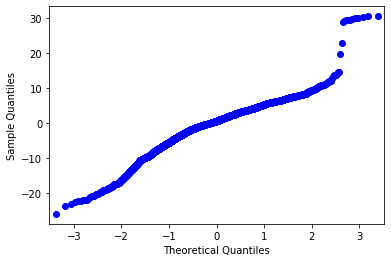

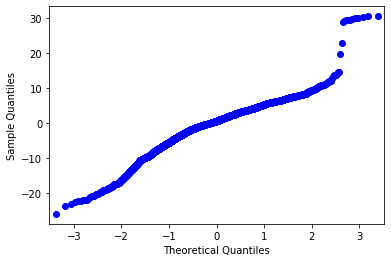

In [197]:
# Create a qq-plot

fsm_resids = fsm.resid

import statsmodels.api as sm
sm.qqplot(fsm_resids)

Those qqplots don't look so good in the upper right corner.

The [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test is performed automatically as part of the model summary output, labeled **Jarque-Bera (JB)** and **Prob(JB)**.

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  
What does the JB score output indicate. Does it support the qq-plot?

In [182]:
'''The JB score has a low p-value means that the current model violates the normality assumption. 
That supports the qq visual with the crooked tail.'''

'The JB score has a low p-value means that the current model violates the normality assumption. \nThat supports the qq visual with the crooked tail.'

#### Homoscadasticity

Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s).  We can visualize this by looking at the predicted life expectancy vs. the residuals.



Interepret the result. Do you see any patterns that suggest that the residuals exhibit heteroscedasticity?


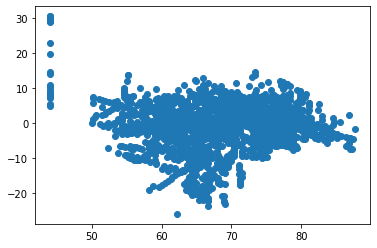

In [211]:

y_hat = fsm.predict()

fig, ax = plt.subplots()

ax.scatter(y_hat, fsm_resids)

In [212]:
'''
Just visually inspecting this, it seems like our model over-predicts life expectancy 
between 60 and 70 years old in a way that doesn't happen for other age groups.  
Plus we have some weird-looking data in the lower end that we might want to inspect.  
Maybe there was something wrong with recording those values, 
or maybe there is something we can feature engineer once we have more independent variables.
'''

"\nJust visually inspecting this, it seems like our model over-predicts life expectancy \nbetween 60 and 70 years old in a way that doesn't happen for other age groups.  \nPlus we have some weird-looking data in the lower end that we might want to inspect.  \nMaybe there was something wrong with recording those values, \nor maybe there is something we can feature engineer once we have more independent variables.\n"

Let's also run a statistical test.  The [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)

The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  
What does the p-value returned above indicate?

In [221]:
'''Thus returning a low p-value means that the current 
model violates the homoscedasticity assumption'''


'Thus returning a low p-value means that the current \nmodel violates the homoscedasticity assumption'

#### Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.